In [4]:
import numpy as np
import cvxpy as cp
np.random.seed(1)
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [5]:
def portfolio_opt(R, gamma):
    T, n = R.shape
    mu = np.mean(R, axis=0)  # Average returns across time
    
    w = cp.Variable(n)  # Assets allocations
    risk = cp.norm(R @ w - mu @ w, 1)
    returns = mu @ w
    objective = cp.Minimize(-returns + gamma * risk)
    constraints = [cp.sum(w) == 1, w >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()

    return w.value

In [6]:
# Load data
prices = pd.read_csv("portfolio_data.csv")
returns = (np.array(prices.iloc[1:,:]) - np.array(prices.iloc[:-1,:])) / prices.iloc[:-1,:]
R = returns.iloc[:2000,:].to_numpy()
R_test = returns.iloc[2000:2500,:].to_numpy()

## Cumulative portfolio value over time

In [7]:
# Cumulative portfolo value over time
def portfolio_V(V_0, r):
    return V_0 * np.cumprod(1 + r)

# Check exact value vs approximation
T = 250
mu, sigma = .10/T, .05/np.sqrt(T)
r = mu + sigma * np.random.randn(T)
V0 = 10000
V = portfolio_V(V0, r)

print("V_T original = ", V[T-1])
print("V_T approx = ", (V0*(1 + np.sum(r))))

V_T original =  11725.21708105774
V_T approx =  11603.396031848863


## Portfolio return, risk and leverage

In [9]:
T, n = R.shape
T_test = R_test.shape[0]
T_year = 250
gamma = 0.00001
w = portfolio_opt(R, gamma)
r = R @ w #Portfolio return time series

def annualize_return(r):
     return 250 * np.sum(r) / len(r)
    
def annualize_risk(r):
    return np.sqrt(250) * np.std(r)

def leverage(w):
    return np.linalg.norm(w, 1)
    

pf_return = annualize_return(r)
pf_risk = annualize_risk(r)
pf_leverage = leverage(w)
print("Portfolio return = %.2f%%" % (pf_return * 100))
print("Portfolio risk = %.2f%%" % (pf_risk * 100))
print("Leverage = %.2f" % (pf_leverage))

Portfolio return = 18.70%
Portfolio risk = 27.28%
Leverage = 1.00


## Optimize for different annualized returns $\rho$

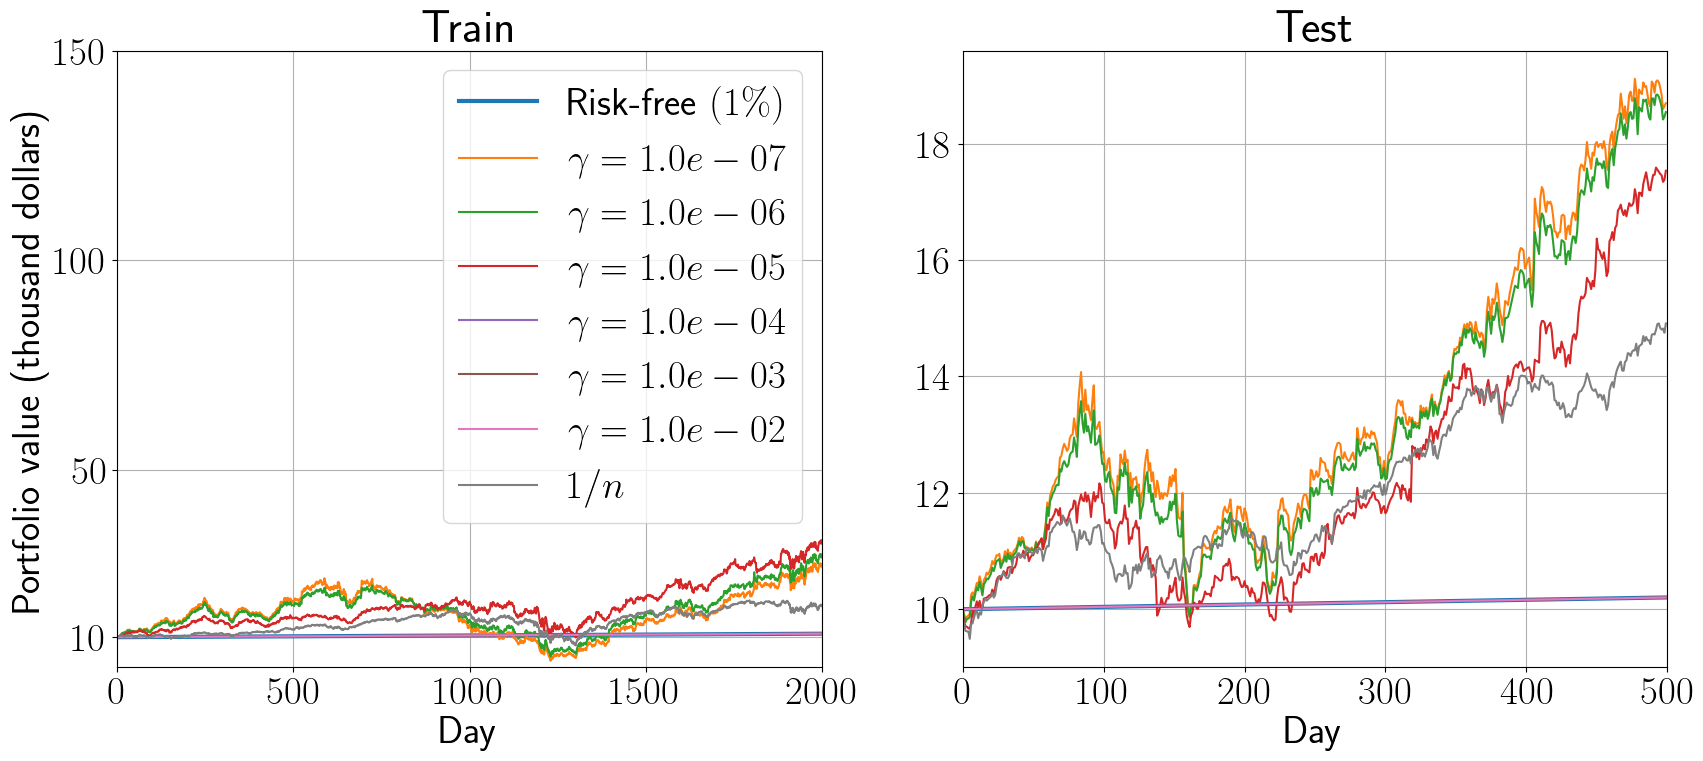

In [10]:
# Optimize for different target returns
V0 = 10000

# Set regularization path for lambda
gamma_vec = np.logspace(-7, -2, 6)

# # Set rhos to target annualized (mean) returns
# # Then, convert them to average per-day returns 
# # by dividing by 250
# rho_vec = np.array([0.1, 0.2, 0.4])
n_assets = R.shape[1]
w_data = {}
results = []

def compute_results(w, r_train, r_test):
    return {'Train return': annualize_return(r_train), 
            'Test return': annualize_return(r_test),
            'Train risk': annualize_risk(r_train),
            'Test risk': annualize_risk(r_test),
            'Leverage': leverage(w)}

fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Risk free
w = np.zeros(n_assets); w[-1] = 1
r_train = R @ w  # Return time series
r_test = R_test @ w  # Test return time series
w_data.update({r"Risk-free $(1\%)$": w})  # append data
results.append(compute_results(w, r_train, r_test)) # append results
ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, linewidth=3, label=r"Risk-free $(1\%)$")
ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000, linewidth=3)

# Different gammas
for k in range(len(gamma_vec)):
    gamma = gamma_vec[k]
    gamma_string = r"$\gamma = {V:.1e}$".format(V=gamma)
    w = portfolio_opt(R, gamma)
    r_train = R @ w  # Return time series
    r_test = R_test @ w  # Test return time series
    w_data.update({gamma_string: w})
    results.append(compute_results(w, r_train, r_test))
    ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=gamma_string)
    ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)
    
# Equal invesetment
w = np.ones(n_assets)/n_assets
r_train = R @ w  # Return time series
r_test = R_test @ w  # Test return time series
w_data.update({r"$1/n$": w})
results.append(compute_results(w, r_train, r_test))
ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=r"$1/n$")
ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)


# Create dataframe from results (round to 2 decimals)
df_results = pd.DataFrame(results).round(2)

# Complete plot
ax[0].set_ylabel("Portfolio value (thousand dollars)")
ax[0].set_title("Train")
ax[0].set_xlabel("Day")
ax[0].set_yticks([10, 50, 100, 150])
ax[0].set_xlim([0, T])
ax[0].grid()
ax[0].legend()
ax[1].set_xlabel("Day")
ax[1].set_title("Test")
ax[1].set_yticks([10, 12, 14, 16, 18])
ax[1].set_xlim([0, T_test])
ax[1].grid()
plt.savefig("total_portfolio.pdf")

In [12]:
w_df = pd.DataFrame(w_data).T.round(2)
w_df.columns = prices.columns
w_df

,American Express,Bank of America,BP,Broadcom,Costco,Cisco Systems,Walt Disney,Goldman Sachs,Hewlett-Packard,Intel,Coca-Cola,3M,Microsoft,Nike,QUALCOMM,Starbucks,AT&T,Tiffany,Verizon,US Dollar
Risk-free $(1\%)$,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
$\gamma = 1.0e-07$,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
$\gamma = 1.0e-06$,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.16,0.00,0.84,0.00,0.00,0.00,0.00
$\gamma = 1.0e-05$,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.72,0.00,0.28,0.00,0.00,0.00,0.00
$\gamma = 1.0e-04$,0.00,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,1.00
$\gamma = 1.0e-03$,0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,1.00
$\gamma = 1.0e-02$,0.00,-0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,1.00
$1/n$,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [13]:
df_results.index = w_df.index  # Use same index to list allocations
df_results

,Train return,Test return,Train risk,Test risk,Leverage
Risk-free $(1\%)$,0.01,0.01,0.00,0.00,1.0
$\gamma = 1.0e-07$,0.19,0.34,0.36,0.24,1.0
$\gamma = 1.0e-06$,0.19,0.33,0.33,0.22,1.0
$\gamma = 1.0e-05$,0.19,0.30,0.27,0.19,1.0
$\gamma = 1.0e-04$,0.01,0.01,0.00,0.00,1.0
$\gamma = 1.0e-03$,0.01,0.01,0.00,0.00,1.0
$\gamma = 1.0e-02$,0.01,0.01,0.00,0.00,1.0
$1/n$,0.10,0.21,0.23,0.13,1.0


In [9]:
# print(df_results.to_latex(index=True, escape=False, float_format=r"$%.2f$"))

## Return vs risk pareto frontier (training data)

In [14]:
# Compute returns for individual investments
individual_data =[]

for k in range(n_assets):
    # w = e_k -> r = Rw = kth column of R
    r = R[:, k]
    individual_data.append({'risk': annualize_risk(r),
                            'return': annualize_return(r)})

df_individual = pd.DataFrame(individual_data)
df_individual.index = w_df.columns
df_individual

,risk,return
American Express,4.256189e-01,0.124480
Bank of America,6.206847e-01,-0.017527
BP,3.164860e-01,0.073021
Broadcom,4.533495e-01,0.139765
Costco,2.510904e-01,0.147587
Cisco Systems,3.303005e-01,0.024846
Walt Disney,3.008461e-01,0.112311
Goldman Sachs,4.299022e-01,0.106326
Hewlett-Packard,3.207904e-01,0.084763
Intel,3.208371e-01,0.043279


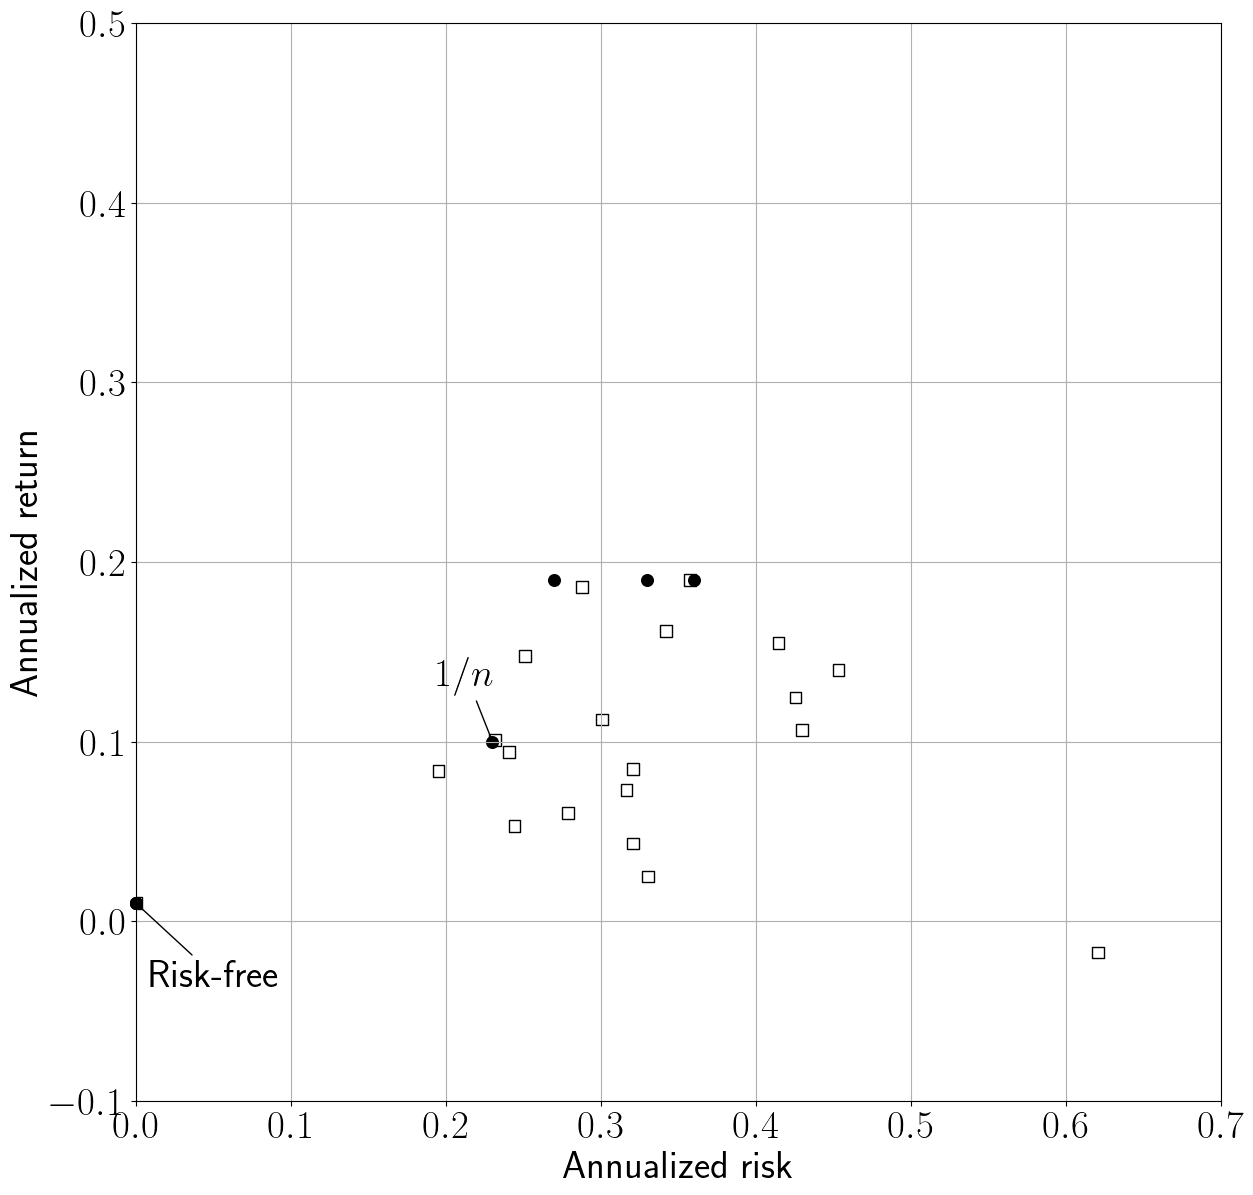

In [16]:
fig, ax = plt.subplots(figsize=(14, 14))
# ax.plot(x_pareto, y_pareto)
ax.scatter(df_individual['risk'], df_individual['return'],  marker='s', s=70, color='k', facecolors='none') 
ax.scatter(df_results['Train risk'], df_results['Train return'],  marker='o', s=70, color='k', facecolors='k', clip_on=False) 

# Annotate risk free and equal investments
ax.annotate(r'Risk-free', 
               (df_results['Train risk'].iloc[0], df_results['Train return'].iloc[0]),
               textcoords="offset points", # how to position the text
               xytext=(10,-60), # distance from text to points (x,y)
               arrowprops=dict(arrowstyle='-', color='k')
              )
ax.annotate(r'$1/n$', 
               (df_results['Train risk'].iloc[-1], df_results['Train return'].iloc[-1]),
               textcoords="offset points", # how to position the text
               xytext=(-40,40), # distance from text to points (x,y)
               arrowprops=dict(arrowstyle='-', color='k')
              )
    
ax.set_xlim((0, 0.7))
ax.set_ylim((-0.1, 0.5))
ax.grid()
ax.set_xlabel("Annualized risk")
ax.set_ylabel("Annualized return")
plt.savefig("pareto_portfolio.pdf")

## Making it interactive

In [18]:
import ipywidgets as widgets
gamma_slider = widgets.FloatLogSlider(
    min=-7,
    max=-2,
    step=1,
    description=r'$\gamma$',
)

@widgets.interact(gamma=gamma_slider)
def plot_portfolio(gamma):
    w = portfolio_opt(R, gamma)
    r_train = R @ w  # Return time series
    r_test = R_test @ w  # Test return time series

    fig, ax = plt.subplots(1, 2, figsize=(20, 8))
    ax[0].plot(np.arange(T), portfolio_V(V0, r_train)/1000, label=r"$\gamma = {V:.1e}$".format(V=gamma))
    ax[1].plot(np.arange(R_test.shape[0]), portfolio_V(V0, r_test)/1000)
    ax[0].set_ylabel("Portfolio value (thousand dollars)")
    ax[0].set_title("Train")
    ax[0].set_xlabel("Day")
#     ax[0].set_yticks([10, 50, 100, 150])
    ax[0].set_xlim([0, T])
    ax[0].set_ylim([5, 50])
    ax[0].grid()
    ax[0].legend()
    ax[1].set_xlabel("Day")
    ax[1].set_title("Test")
    ax[1].set_ylim([5, 50])
#     ax[1].set_yticks([10, 12, 14, 16, 18])
    ax[1].set_xlim([0, T_test])
    ax[1].grid()

interactive(children=(FloatLogSlider(value=0.01, description='$\\gamma$', max=-2.0, min=-7.0, step=1.0), Outpu…